In [ ]:
import numpy as np

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-6, random_state=None):
        # step 1: Initialize model parameters
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.history = {'log_likelihood': []} # Initialize history of log-likelihood values

    def fit(self, X):
        # step 2: Initialize the model
        n_samples, n_features = X.shape
        np.random.seed(self.random_state)
        self.mu = np.random.randn(self.n_components, n_features)
        self.sigma = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.ones(self.n_components) / self.n_components

        # step 3: Run EM algorithm to learn model parameters
        for iteration in range(self.max_iter):
            # E-step: compute responsibilities
            responsibilities = self._compute_responsibilities(X)

            # M-step: update model parameters
            self._update_parameters(X, responsibilities)

            # check convergence
            if self._converged(X, responsibilities):
                break

    def predict(self, X):
        # step 4: Predict cluster assignments for each data point
        responsibilities = self._compute_responsibilities(X)
        return np.argmax(responsibilities, axis=1)

    def _compute_responsibilities(self, X):
        # compute the responsibilities of each Gaussian component for each data point
        responsibilities = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            responsibilities[:, i] = self._multivariate_pdf(X, self.mu[i], self.sigma[i]) * self.weights[i]
        responsibilities /= np.sum(responsibilities, axis=1)[:, np.newaxis]
        return responsibilities

    def _update_parameters(self, X, responsibilities):
        # update the mean, covariance, and weight parameters of each Gaussian component
        total_weight = np.sum(responsibilities, axis=0)
        self.weights = total_weight / X.shape[0]
        self.mu = np.dot(responsibilities.T, X) / total_weight[:, np.newaxis]
        for i in range(self.n_components):
            diff = X - self.mu[i]
            self.sigma[i] = np.dot(responsibilities[:, i] * diff.T, diff) / total_weight[i]

    def _converged(self, X, responsibilities):
        # check if the model parameters have converged
        if len(self.history['log_likelihood']) > 1:
            delta = self.history['log_likelihood'][-1] - self.history['log_likelihood'][-2]
            if delta < self.tol:
                return True
        self.history['log_likelihood'].append(self._compute_log_likelihood(X, responsibilities))
        return False

    def _compute_log_likelihood(self, X, responsibilities):
        # compute the log likelihood of the data given the current model parameters
        joint_probabilities = np.zeros(X.shape[0])
        for i in range(self.n_components):
            joint_probabilities += self._multivariate_pdf(X, self.mu[i], self.sigma[i]) * self.weights[i]
        return np.log(joint_probabilities).sum()

    def _multivariate_pdf(self, X, mean, covariance):
        # compute the multivariate probability density function
        det_covariance = np.linalg.det(covariance)
        inv_covariance = np.linalg.inv(covariance)
        diff = X - mean
        exponent = np.sum(np.dot(diff, inv_covariance) * diff, axis=1)
        normalization_factor = 1.0 / (np.power(2*np.pi, X.shape[1]/2) * np.sqrt(det_covariance))
        return normalization_factor * np.exp(-0.5 * exponent)


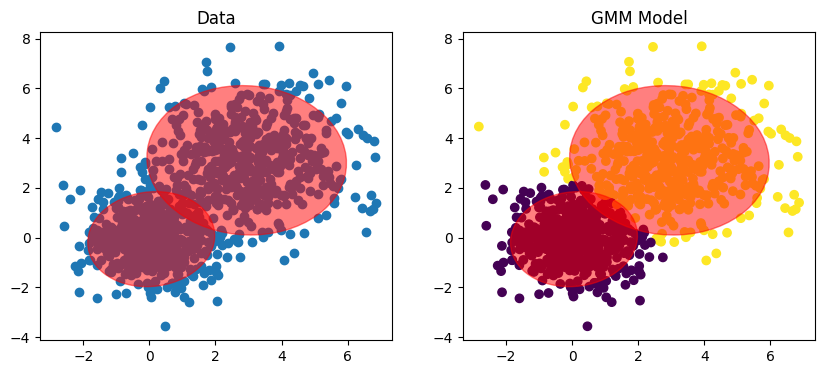

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_gaussian_ellipse(ax, mu, sigma, alpha=0.5, color='red'):
    eigenvalues, eigenvectors = np.linalg.eigh(sigma)
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
    ellipse = Ellipse(xy=mu, width=2*np.sqrt(eigenvalues[1])*2,
                      height=2*np.sqrt(eigenvalues[0])*2,
                      angle=angle, alpha=alpha, color=color)
    ax.add_artist(ellipse)


# generate random data
np.random.seed(1234)
n_samples = 1000
X = np.vstack([
    np.random.normal(loc=0.0, scale=1.0, size=(n_samples//2, 2)),
    np.random.normal(loc=3.0, scale=1.5, size=(n_samples//2, 2))
])

# fit GMM model to data
gmm = GMM(n_components=2, max_iter=100)
gmm.fit(X)

# plot data and GMM model
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].scatter(X[:, 0], X[:, 1])
ax[0].set_title('Data')
for i in range(gmm.n_components):
    plot_gaussian_ellipse(ax[0], gmm.mu[i], gmm.sigma[i], alpha=0.5)
ax[1].scatter(X[:, 0], X[:, 1], c=gmm.predict(X))
ax[1].set_title('GMM Model')
for i in range(gmm.n_components):
    plot_gaussian_ellipse(ax[1], gmm.mu[i], gmm.sigma[i], alpha=0.5)
plt.show()
